In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D4_t_I7000_F9000/D4_t.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,100,7000,9000,400.35
1,0.0000,-0.00192,100,7000,9000,416.89
2,0.0000,-0.00184,100,7000,9000,432.05
3,0.0000,-0.00176,100,7000,9000,445.87
4,0.0000,-0.00168,100,7000,9000,458.33
...,...,...,...,...,...,...
43906,0.0024,0.00168,500,7000,9000,775.40
43907,0.0024,0.00176,500,7000,9000,715.43
43908,0.0024,0.00184,500,7000,9000,645.85
43909,0.0024,0.00192,500,7000,9000,585.87


In [3]:
df = data.drop(data.columns[3:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Zeitpunkt,Temperatur
0,0.0000,-0.00200,100,400.35
1,0.0000,-0.00192,100,416.89
2,0.0000,-0.00184,100,432.05
3,0.0000,-0.00176,100,445.87
4,0.0000,-0.00168,100,458.33
...,...,...,...,...
43906,0.0024,0.00168,500,775.40
43907,0.0024,0.00176,500,715.43
43908,0.0024,0.00184,500,645.85
43909,0.0024,0.00192,500,585.87


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Zeitpunkt  Temperatur
38620       0.00012      -0.00096        460     1229.80
14428       0.00108       0.00168        230      542.76
14359       0.00096       0.00024        230      777.04
21104       0.00168       0.00128        290      720.23
28698       0.00192       0.00088        360      886.28
...             ...           ...        ...         ...
6265        0.00204       0.00144        150      539.86
11284       0.00132      -0.00096        200      690.53
38158       0.00156      -0.00120        450     1049.80
860         0.00192       0.00152        100      464.69
15795       0.00180       0.00088        240      715.22

[43911 rows x 4 columns]


,X-Koordinate,Y-Koordinate,Zeitpunkt,Temperatur
0,0.00012,-0.00096,460,1229.80
1,0.00108,0.00168,230,542.76
2,0.00096,0.00024,230,777.04
3,0.00168,0.00128,290,720.23
4,0.00192,0.00088,360,886.28
...,...,...,...,...
43906,0.00204,0.00144,150,539.86
43907,0.00132,-0.00096,200,690.53
43908,0.00156,-0.00120,450,1049.80
43909,0.00192,0.00152,100,464.69


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X

,X-Koordinate,Y-Koordinate,Zeitpunkt
0,0.00012,-0.00096,460
1,0.00108,0.00168,230
2,0.00096,0.00024,230
3,0.00168,0.00128,290
4,0.00192,0.00088,360
...,...,...,...
43906,0.00204,0.00144,150
43907,0.00132,-0.00096,200
43908,0.00156,-0.00120,450
43909,0.00192,0.00152,100


In [7]:
y

0        1229.80
1         542.76
2         777.04
3         720.23
4         886.28
          ...   
43906     539.86
43907     690.53
43908    1049.80
43909     464.69
43910     715.22
Name: Temperatur, Length: 43911, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.05 , 0.66 , 0.275],
       [0.8  , 0.02 , 0.525],
       [0.6  , 0.2  , 0.525],
       ...,
       [0.45 , 0.92 , 0.975],
       [0.3  , 0.7  , 0.875],
       [0.75 , 1.   , 0.275]])

In [11]:
y_train_scaled.max()

0.9999999999999999

In [137]:
# Netzwerkarchitektur
model = Sequential([

    Dense(304, activation='relu', input_shape=(3,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)), 

    
    Dense(304, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    
    Dense(208, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    
    Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    
    Dense(208, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    
    Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    
    Dense(304, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 50  #200
epochs = 1000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
563/563 [==============================] - 3s 3ms/step - loss: 0.1122 - mae: 0.1536 - val_loss: 0.0381 - val_mae: 0.0757
Epoch 2/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0368 - mae: 0.0697 - val_loss: 0.0357 - val_mae: 0.0657
Epoch 3/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0348 - mae: 0.0632 - val_loss: 0.0341 - val_mae: 0.0614
Epoch 4/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0333 - mae: 0.0589 - val_loss: 0.0325 - val_mae: 0.0564
Epoch 5/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0318 - mae: 0.0544 - val_loss: 0.0310 - val_mae: 0.0521
Epoch 6/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0304 - mae: 0.0501 - val_loss: 0.0299 - val_mae: 0.0474
Epoch 7/1000
563/563 [==============================] - 1s 2ms/step - loss: 0.0293 - mae: 0.0465 - val_loss: 0.0287 - val_mae: 0.0442
Epoch 8/1000
563/563 [==============================] - 1s 2ms

In [138]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

275/275 - 0s - loss: 7.1859e-04 - mae: 0.0032 - 305ms/epoch - 1ms/step


[0.0007185922586359084, 0.0032314227428287268]

In [139]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

 Bsp. Predicted: [599.3018] Actual: [596.74] 
Durchschnittliche Abweichung (MAE): [3.710735]


In [136]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]
df_result['Zeitpunkt'] = X_test_scaled[:, 2]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] < -5).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df


Anzahl der Werte die kleiner sind: 409


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Zeitpunkt,Differenz
5913,646.649292,673.72,1.0,0.94,0.700,-27.070708
6769,519.637390,543.98,1.0,0.94,0.225,-24.342610
1950,510.743866,533.12,1.0,0.94,0.200,-22.376134
3132,581.454895,602.50,1.0,0.90,0.275,-21.045105
513,501.738129,522.43,1.0,0.94,0.175,-20.691871
...,...,...,...,...,...,...
3222,414.040405,397.49,1.0,0.98,0.075,16.550405
573,428.338715,409.84,1.0,0.98,0.125,18.498715
7585,447.129974,428.07,1.0,0.98,0.200,19.059974
5445,744.155884,724.42,0.0,0.02,1.000,19.735884


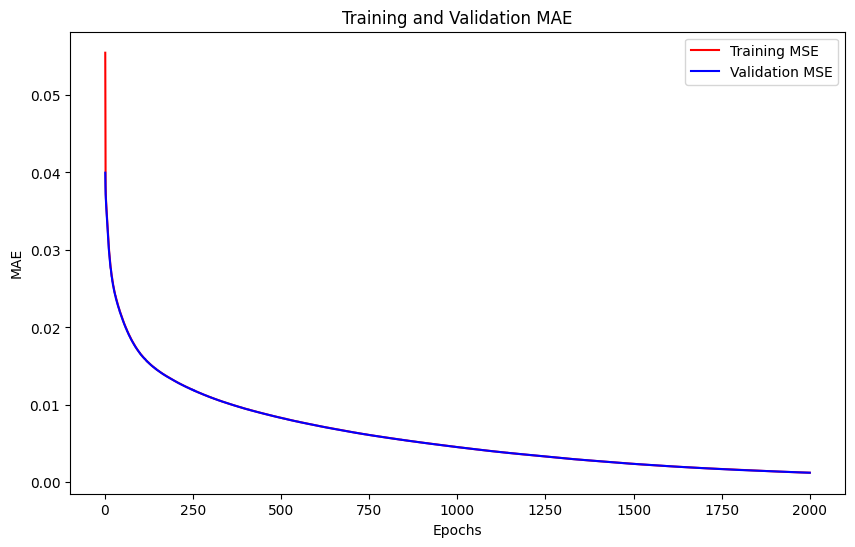

In [125]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

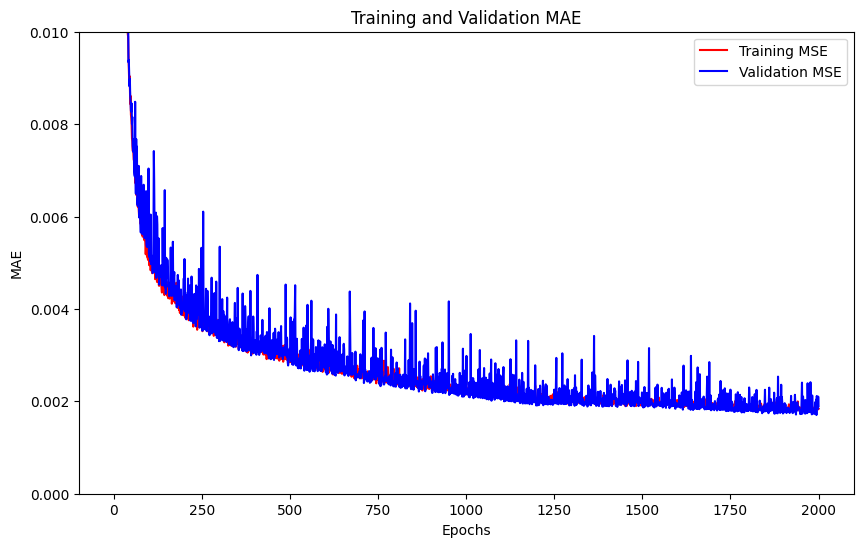

In [128]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()


#plt.ylim(0.00, 0.01)


plt.show()

# GridSearch

In [86]:
def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(448, activation=activation, input_shape=(3,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(384, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(320, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(256, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))    

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
model = KerasRegressor(model=build_model, verbose=2, callbacks=[early_stopping])

# Anpassung der Parameter im param_grid
param_grid = {
    'model__learning_rate': [0.001, 0.0001],
    'model__regularization': [0.001, 0.0001],
    'fit__batch_size': [10, 25, 50, 75],
    'fit__epochs': [50],
    'model__dropout_rate' : [0.0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

with open("Gridsearch_D4.txt", "w") as f:
    f.write(f"Beste Parameter: {grid_search.best_params_}\n")
    f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


ValueError: 
All the 216 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filelq3xb2yy.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file_5dp_8eu.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileul2tjlq1.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filepiwpev5p.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file916jvh8i.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file4wotnf0m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_filebpanjzlp.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file9_gi1a3m.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_file5lrfagcl.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileq5bddd1k.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileecwoh6s0.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\AppData\Local\Temp\__autograph_generated_fileqzdromut.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 3)



In [16]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=16, max_value=656, step=32), input_shape=(3,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=16, max_value=656, step=32), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D4_t_{run}'
#     
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=2,
#         directory=directory,
#         project_name=project_name
#     )
#     
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
#     
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
#     
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
#     
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D4_t_{run}.csv', index=False)
#     
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")


KeyboardInterrupt: 